In [1]:
import time 
import math
import re
import json

from datasets import load_dataset_builder, load_dataset

from bs4 import BeautifulSoup

import spacy

import numpy as np
import pandas as pd

import gensim.models
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# ds_builder = load_dataset_builder('emotion')
# dataset = load_dataset("emotion")

# train_data = pd.DataFrame(dataset['train'])
# validation_data = pd.DataFrame(dataset['validation'])
# test_data = pd.DataFrame(dataset['test'])
# data = pd.concat([train_data, validation_data, test_data])

In [3]:
# ds_builder = load_dataset_builder('yelp_review_full')
# dataset = load_dataset("yelp_review_full")

# train_data = pd.DataFrame(dataset['train'])
# test_data = pd.DataFrame(dataset['test'])
# data = pd.concat([train_data, test_data])

In [4]:
# def assignLabel(label):
#     if label == 0 or label == 1:
#         return 'negative'
#     elif label == 2:
#         return 'neutral'
#     else:
#         return 'positive'

In [5]:
# data['label'] = data['label'].apply(assignLabel)
# data

In [6]:
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

In [7]:
# extracting text from tags 
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# removing square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# lemmatization and removal of stop words
def lemma(text):
    doc = nlp(str(text).lower())
    lemmas = [token.lemma_ for token in doc 
          if (token.lemma_.isalnum() or token.lemma_ in ['.', '!', '?'] ) and token.lemma_ not in stopwords]
    if len(lemmas) < 2: 
        lemmas.insert(0, 'start')
        lemmas.append('end')
    text = ' '.join(lemmas)
    return text

# cleaning text
def clean(text):
    text = str(text)
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = lemma(text)
    return text

In [8]:
# data.to_csv('./data/yelp.csv', index=False)
# data_clean = data.copy()
# data_clean['text'] = data['text'].apply(clean)
# data_clean.to_csv('./data/yelp_clean.csv', index=False)

In [9]:
# data.to_csv('./data/data.csv', index=False)
# data_clean = data.copy()
# data_clean['text'] = data['text'].apply(clean)
# data_clean.to_csv('./data/data_clean.csv', index=False)

In [10]:
data_clean = pd.read_csv('./data/yelp_clean.csv')
data_clean
# data_clean = pd.read_csv('./data/IMDB_Dataset_Clean.csv')
# data_clean
# data_clean = pd.read_csv('./data/data_clean.csv')
# data_clean

,label,text
0,positive,dr . goldberg offer I look general practitione...
1,negative,unfortunately frustration dr . goldberg patien...
2,positive,dr . goldberg 10 year . I think I 1st patient ...
3,positive,letter mail week dr . goldberg arizona new pos...
4,negative,I know dr . goldberg like arizona let I tell s...
...,...,...
699995,negative,want write review chip . I recommend . little ...
699996,positive,great ambience . great drink . great food . I ...
699997,positive,I monk location I excite I hear come sun prair...
699998,negative,. I know want try good review people sadly tas...


In [ ]:
data

In [11]:
sentences = []
_ = [sentences.append(x.split()) for x in data_clean['text']]

In [12]:
t = time.time()

word2vec_model = gensim.models.Word2Vec(
    sentences=sentences,
    window=10,
    min_count=1,
    negative=5,
    vector_size=100, 
    workers=12)

word2vec_model.save('./saved_models/word2vec_model')

print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to build vocab: 0.81 mins


In [13]:
word2vecDict = {}
for index, word in enumerate(word2vec_model.wv.index_to_key):
    word2vecDict[word] = word2vec_model.wv.vectors[index]

In [14]:
list(word2vecDict.keys())[:10]

['.', 'I', '!', 'good', 'place', 'food', 'like', 'time', 'order', 'come']

In [15]:
data_vectorized = []
for text in data_clean['text']:
    temp = []
    for word in text.split():
        temp.append(word2vecDict[word])
    data_vectorized.append(np.array(temp))

In [16]:
# first 3 words of first text
print(data_clean['text'][0].split()[:3])
print('\n')
print(data_vectorized[0][:3])

['dr', '.', 'goldberg']


[[ 2.67786574e+00  7.13899994e+00  4.18790722e+00  1.53078806e+00
  -1.84095550e+00  3.46348238e+00  1.40430987e+00  1.40777898e+00
  -2.56280422e+00 -2.74677181e+00 -2.43860221e+00 -1.30620623e+00
   9.09476876e-01  1.73891932e-02 -2.55047178e+00 -1.66788900e+00
   4.24955416e+00 -1.42414618e+00  7.66681612e-01 -5.49790096e+00
  -6.88480139e-01 -9.06577587e-01  2.86911058e+00 -1.21197557e+00
   1.03321040e+00 -1.91503191e+00 -4.87905407e+00  3.98098612e+00
   2.97197819e-01 -2.00659990e+00  1.88588142e+00 -8.08712721e-01
   4.24121237e+00 -1.38506711e+00 -2.24521112e+00  4.56653452e+00
  -1.02624941e+00 -1.38573849e+00 -2.06298041e+00  9.72352743e-01
  -2.29572606e+00 -1.63519919e-01 -3.25608993e+00  8.05527210e-01
  -3.17897534e+00  1.42789412e+00 -1.97183836e+00  3.17938852e+00
   1.85930455e+00  7.19727564e+00  2.87811875e+00 -7.45842743e+00
   1.08862400e+00 -1.08678312e+01 -6.27434969e-01  5.44657803e+00
  -3.49116921e-01 -3.06740344e-01 -1.89172905e-02 

In [17]:
# encoding sentiment
le = preprocessing.LabelEncoder()
data_label = le.fit_transform(data_clean['label'])

In [18]:
# train, validation, test: 80/10/10 
X_train, X_test, y_train, y_test = train_test_split(data_vectorized, data_label, test_size=1/4, random_state=1)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=1/2, random_state=1)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout, bidirectional):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        if bidirectional: self.bidirectional = 2
        else: self.bidirectional = 1
        
        if num_layers < 2:
            dropout = 0
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size*self.bidirectional, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden, c):
        output, (hidden, c) = self.lstm(input, (hidden, c))
        output = self.dropout(output)
        output = output.squeeze()[-1].unsqueeze(0)
        output = self.fc(output)
        output = self.softmax(output)
        return output, hidden, c
    
    def initHidden(self):
        return torch.zeros(self.bidirectional*self.num_layers, 1, self.hidden_size, device=device)
    def initC(self):
        return torch.zeros(self.bidirectional*self.num_layers, 1, self.hidden_size, device=device)

In [21]:
def getLabel(output):
#     print(output)
#     print(output.topk(1))
    value_tensor, index_tensor = output.topk(1)
    return index_tensor[0].item()

In [22]:
def getElapsedTime(start_time):
    current_time = time.time()
    s = current_time - start_time
    m = math.floor(s / 60)
    s -= m * 60
    return '{}m {:.0f}s'.format(m, s)

In [23]:
def train(X_train, y_train):
    hidden, c = lstm.initHidden(), lstm.initC()
    lstm.zero_grad()
    output, hidden, c = lstm(X_train, hidden, c)
    loss = criterion(output, y_train)
    loss.backward()
    nn.utils.clip_grad_norm_(lstm.parameters(), 5)
    optimizer.step()

    return output, loss.item()

In [37]:
from sklearn.metrics import f1_score

In [38]:
def test(X_test, y_test):
    
    n = len(X_test)
#     n = 200

    print_every = 1000
    
    correct = 0
    total_loss = 0
    
    y_pred = []
    
    for i in range(n):
        with torch.no_grad():
            hidden, c = lstm.initHidden(), lstm.initC()
            output, hidden, c = lstm(torch.tensor(X_test[i], device=device).unsqueeze(1), hidden, c)
            loss = criterion(output, torch.tensor([y_test[i]], dtype=torch.long, device=device))
            total_loss+=loss.item()
            
            y_pred.append(getLabel(output))
            if y_pred[-1] == y_test[i]:
                correct+=1
            
            if i>0 and i%print_every == 0:
                pass
#                 print('Test Sample {} | {:.2f}%'.format(i, i*100/n))
                
                
    accuracy = correct / n
    total_loss = total_loss / n
    f1 = f1_score(y_test, y_pred, average='micro')
    
    return accuracy, f1, total_loss

In [27]:
# strict parameters
input_size = len(X_train[0][0])
output_size = len(le.classes_)

# adjustable parameters
hidden_size = 256
num_layers = 1
dropout = .2
bidirectional = False


lstm = LSTM(input_size, hidden_size, output_size, num_layers, dropout, bidirectional)
criterion = nn.NLLLoss()
lr = 0.001

optimizer = torch.optim.SGD(lstm.parameters(), lr=lr)

Epoch 0 Sample 131250 | 25% | (10m 55s) | Loss: 4.2330 | Wrong! Guessed 0 but should be: 1
Epoch 0 Sample 262500 | 50% | (21m 49s) | Loss: 0.1141 | Correct! It's 0
Epoch 0 Sample 393750 | 75% | (32m 41s) | Loss: 0.0823 | Correct! It's 2
Epoch 0 Sample 524999 | 99% | (43m 46s) | Loss: 1.4243 | Wrong! Guessed 1 but should be: 2




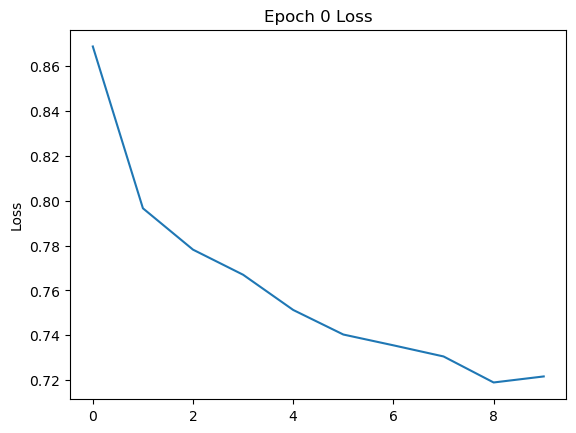

Epoch 1 Sample 131250 | 25% | (56m 48s) | Loss: 5.5505 | Wrong! Guessed 2 but should be: 0
Epoch 1 Sample 262500 | 50% | (67m 42s) | Loss: 0.1490 | Correct! It's 1
Epoch 1 Sample 393750 | 75% | (78m 31s) | Loss: 0.0310 | Correct! It's 2
Epoch 1 Sample 524999 | 99% | (89m 18s) | Loss: 0.0087 | Correct! It's 0




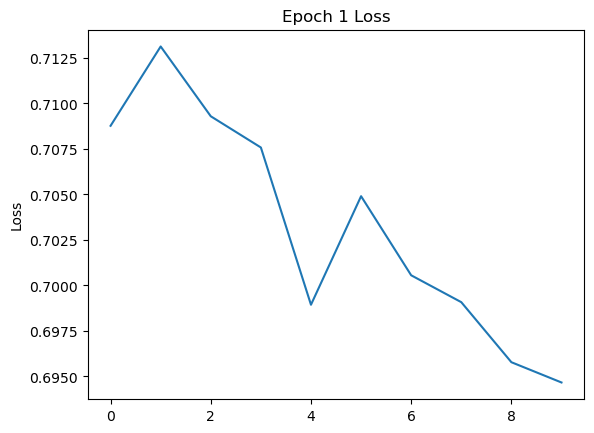

Epoch 2 Sample 131250 | 25% | (102m 39s) | Loss: 0.1281 | Correct! It's 2


KeyboardInterrupt: 

In [28]:
epochs = 15
n = len(X_train)
# n = 1000

print_every = n/4
plot_every = n/10

start_time = time.time()

total_epoch_loss = []
total_validation_loss = []

total_validation_accuracy = []

for epoch in range(epochs):
    
    X_train, y_train = shuffle(X_train, y_train)
    
    epoch_loss = []
    current_loss = 0
    
    lstm.to(device)
    lstm.train()
        
    for i in range(n): 
        output, loss = train(torch.tensor(X_train[i], device=device).unsqueeze(1).to(device), torch.tensor([y_train[i]], dtype=torch.long, device=device).to(device))
        current_loss += loss
    
        if (i>0 and i % print_every == 0) or i==n-1:
            y_pred = getLabel(output)
            if y_pred == y_train[i]:
                y_pred = "Correct! It's {}".format(y_pred)  
            else:
                y_pred = 'Wrong! Guessed {} but should be: {}'.format(y_pred, y_train[i])
        
            print('Epoch %d Sample %d | %d%% | (%s) | Loss: %.4f | %s' % (epoch, i, i / n * 100, getElapsedTime(start_time), loss, y_pred))

        if (i>0 and i % plot_every == 0) or i==n-1:
            epoch_loss.append(current_loss / plot_every)
            current_loss = 0
    
    print('\n')
            
    # training loss
    training_loss = sum(epoch_loss) / len(epoch_loss)
    
    # validation loss
    lstm.eval()
    validation_accuracy, validation_loss = test(X_validation, y_validation)
    
    # save metrics if continuing
    total_epoch_loss.append(training_loss)
    total_validation_accuracy.append(validation_accuracy)
    total_validation_loss.append(validation_loss)
    
    # save model
    torch.save(lstm.state_dict(), './saved_models/lstm_epoch_{}.pth'.format(epoch))
    
    # plot current epoch loss
    plt.title('Epoch {} Loss'.format(epoch))
    plt.plot(epoch_loss)
    plt.ylabel('Loss')
    plt.show()

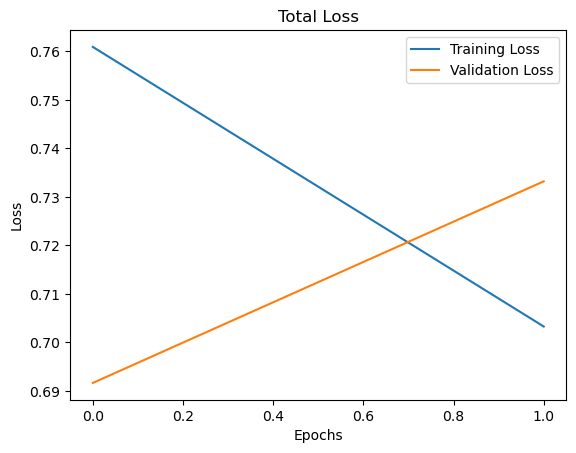

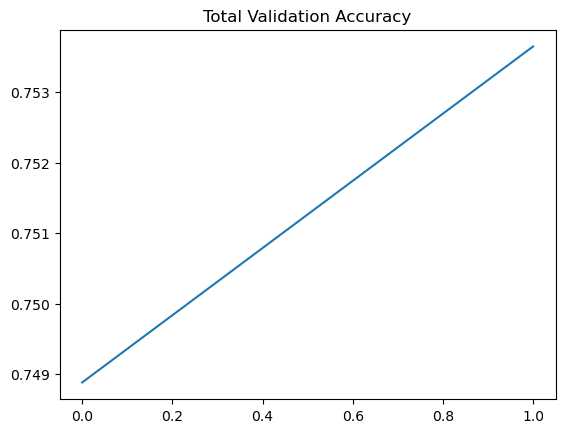

In [29]:
plt.title('Total Loss')
plt.plot(range(len(total_epoch_loss)), total_epoch_loss, label='Training Loss')
plt.plot(range(len(total_validation_loss)), total_validation_loss, label= 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.title('Total Validation Accuracy')
plt.plot(total_validation_accuracy)
plt.show()

In [39]:
# final test
test_accuracy, f1, test_loss = test(X_test, y_test)
print(test_accuracy)
print(f1)

0.7581942857142857
0.7581942857142856
